In [1]:
%load_ext slim_magic
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display, SVG

# slim_magic examples
First let's set up a simple, single locus simulation of drift. The cell below contains all the
SLiM code to be run. We hand that to a magic function, in this case `slim_stats_reps_cstack` along with
the required parameters of that function. In this case `slim_stats_reps_cstack` wants to know the number of reps
to run as well as optionally a variable name to store resulting output.

In [2]:
%%slim_stats_reps_cstack 200 --out output_from_magic
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 early() {
    sim.addSubpop("p1", 100);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 100);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    log = community.createLogFile("/dev/stdout", logInterval=1);
    log.addCycle();
    log.addCustomColumn("H", "calcHeterozygosity(p1.genomes);"); 
}

// run to generation 0
300 late() {
    sim.simulationFinished();
}


In [3]:
%%slim_stats_reps_cstack 3 --out output_from_magic --param_vec mu 0.1 0.2 0.3 --param_vec rho 0.1 0.2 0.3
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(mu);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(rho);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 early() {
    sim.addSubpop("p1", 100);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 100);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    log = community.createLogFile("/dev/stdout", logInterval=1);
    log.addCycle();
    log.addCustomColumn("H", "calcHeterozygosity(p1.genomes);"); 
}

// run to generation 0
300 late() {
    sim.simulationFinished();
    }

In [28]:
output_from_magic 

,H,H,H
generation,,,
1,0.74630,0.78405,1.08700
2,1.03550,1.23420,1.60765
3,1.11485,1.60865,2.37730
4,1.33995,1.91710,2.93330
5,1.59040,2.40865,3.44315
...,...,...,...
296,23.47750,80.58430,61.25430
297,22.53230,82.67430,59.59880
298,22.85610,80.27350,61.49090


In [5]:
# function for drift expectation
def exp_decay_drift(H0, N, gens):
    res = [H0]
    h = H0
    for i in range(gens):
        tmp = h * (1 - (1 / (2*N)))
        res.append(tmp)
        h = tmp
    return res

e = exp_decay_drift(0.5, 100, 299)

plot mean Heterozygosity across reps versus the expected value

<Axes: xlabel='cycle', ylabel='heterozygosity'>

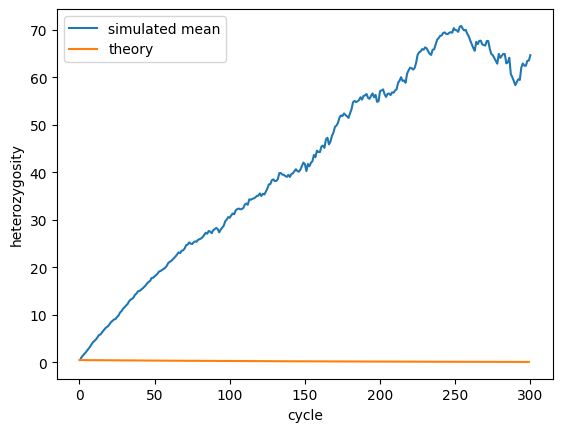

In [6]:
output_from_magic.mean(axis=1).plot(ylabel="heterozygosity", label="simulated mean", legend=True)
pd.Series(e).plot(label="theory",legend="True")

## Hardy Weinberg

In [10]:
%%slim_stats_reps_rstack 10 --out df
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 early() {
    sim.addSubpop("p1", 100);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 100);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    cat("cycle,p,x11,x12,x22\\n");
}
1:300 late(){
    inds = p1.sampleIndividuals(100);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs = sim.mutationFrequencies(p1);
    if (length(freqs) > 0.0)
        catn(sim.cycle + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


## HWE Expectations
let's write a function to compute the HW expected genotype frequencies from the allele frequency, $p$

In [11]:
def hwe(p):
    return np.array([p**2, 2 * p * (1 - p), (1 - p)**2])

#run that function for 100 pts between (0,1)
expected = hwe(np.linspace(0,1,100))

Text(0, 0.5, 'genotype frequency')

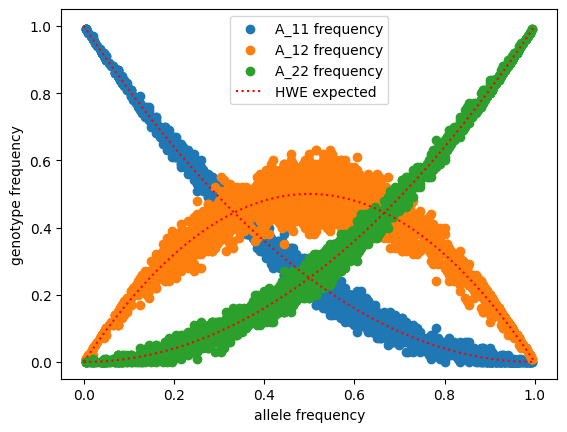

In [13]:
#plot simulated
plt.scatter(df.p, df.x11, label="A_11 frequency")
plt.scatter(df.p, df.x12, label="A_12 frequency")
plt.scatter(df.p, df.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

# Deviations from HWE
let's simulate a deviation from HWE and compare the output to above

In [15]:
%%slim_stats_reps_rstack 10 --out df
// set up a single locus simulation of drift
initialize()
{
    // set the overall mutation rate
    initializeMutationRate(0);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 0);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-8);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 early() {
    sim.addSubpop("p1", 50);
    sim.addSubpop("p2", 50);
    // sample 100 haploid genomes 
    target = sample(p1.genomes, 50);
    // add a mutation to those genomes
    // H_0 = 0.5 here
    target.addNewMutation(m1,0, 0);
    cat("cycle,p,x11,x12,x22\\n");
}
1:300 late(){
    inds1 = p1.sampleIndividuals(50);
    inds2 = p2.sampleIndividuals(50);
    inds = c(inds1, inds2);
    ind_count = inds.countOfMutationsOfType(m1);
    counts = c(0, 0, 0);
    for (x in ind_count)
        counts[x] = counts[x] + 1;
    counts = counts / 100;
    freqs1 = sim.mutationFrequencies(p1);
    freqs2 = sim.mutationFrequencies(p2);
    freqs = freqs1 + freqs2;
    if (length(freqs) > 0.0)
        catn(sim.cycle + "," + freqs + "," + paste(counts, sep=","));
    }
// run to generation 0
300 late() {
    sim.simulationFinished();
    }


Text(0, 0.5, 'genotype frequency')

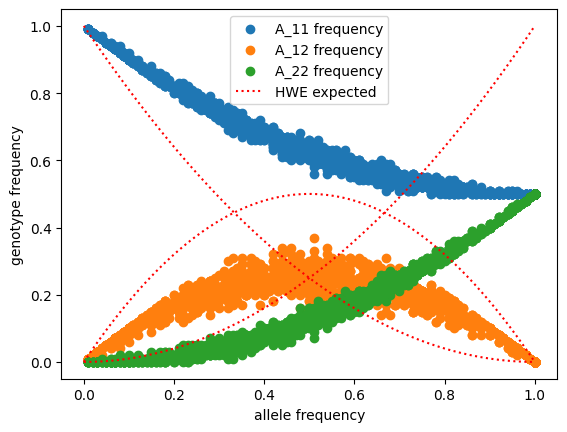

In [16]:
#plot simulated
plt.scatter(df.p, df.x11, label="A_11 frequency")
plt.scatter(df.p, df.x12, label="A_12 frequency")
plt.scatter(df.p, df.x22, label="A_22 frequency")


#plot expected
plt.plot(np.linspace(0,1,100),expected[0,:], c="red", linestyle="dotted", label="HWE expected")
plt.plot(np.linspace(0,1,100),expected[1,:], c="red", linestyle="dotted")
plt.plot(np.linspace(0,1,100),expected[2,:], c="red", linestyle="dotted")

plt.legend()
plt.xlabel("allele frequency")
plt.ylabel("genotype frequency")

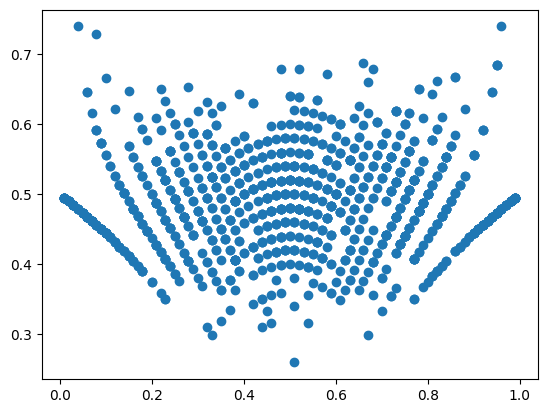

In [17]:
# Plot F as a function of allele frequency here
F = 1.0 - (df.x12 / (2 * df.p * (1-df.p)))
plt.scatter(df.p,F)

## Tree Sequences
`%%slim_ts` will return a tree sequence object from slim

In [23]:
%%slim_ts --out ts
// set up a simulation of drift
initialize()
{
    // set tree seq recording
    initializeTreeSeq(checkCoalescence=T);
    // set the overall mutation rate
    initializeMutationRate(1e-7);
    // m1 mutation type: neutral
    initializeMutationType("m1", 0.5, "f", 0.0);
    // g1 genomic element type: uses m1 probability 1
    initializeGenomicElementType("g1", c(m1), c(1.0));
    // uniform chromosome of length 1 site
    initializeGenomicElement(g1, 0, 10000);
    // uniform recombination along the chromosome
    initializeRecombinationRate(1e-7);
    suppressWarnings(T);
}

// create a population of 100 individuals
1 early() {
    sim.addSubpop("p1", 100);
}

// run to generation 0
300 late() {
    sim.treeSeqOutput("tmp.trees");
    sim.simulationFinished();
    }

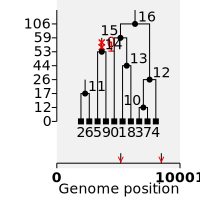

In [24]:
# simplify ts to 10 samples and draw pretty pic
tss = ts.simplify(samples=ts.samples()[0:10])

svg_string = tss.draw_svg(
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", 
)
display(SVG(svg_string))  # If the last line in a cell, wrapping this in display() is not needed

In [25]:
print(tss.draw_text())

106.00┊     16              ┊  
      ┊   ┏━━┻━━┓           ┊  
59.00 ┊  15     ┃           ┊  
      ┊ ┏━┻┓    ┃           ┊  
53.00 ┊ ┃  ┃    ┃       14  ┊  
      ┊ ┃  ┃    ┃       ┏┻┓ ┊  
44.00 ┊ ┃ 13    ┃       ┃ ┃ ┊  
      ┊ ┃ ┏┻┓   ┃       ┃ ┃ ┊  
26.00 ┊ ┃ ┃ ┃  12       ┃ ┃ ┊  
      ┊ ┃ ┃ ┃  ┏┻━┓     ┃ ┃ ┊  
17.00 ┊ ┃ ┃ ┃  ┃  ┃ 11  ┃ ┃ ┊  
      ┊ ┃ ┃ ┃  ┃  ┃ ┏┻┓ ┃ ┃ ┊  
12.00 ┊ ┃ ┃ ┃ 10  ┃ ┃ ┃ ┃ ┃ ┊  
      ┊ ┃ ┃ ┃ ┏┻┓ ┃ ┃ ┃ ┃ ┃ ┊  
0.00  ┊ 0 1 8 3 7 4 2 6 5 9 ┊  
      0                   10001

